In [1]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
import math

In [2]:
rootfolder = '../data/'

Generating 1-D DCT basis
------------------------


In [3]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    ek = []
    for n in range(N):
        if k==0:
            ck = math.sqrt(1/M) #c0
        else:
            ck = math.sqrt(2/M)
        
        argument = math.cos(k*math.pi*(((2*n)+1)/(2*M)))
        ek.append(ck * argument) # actual vector

    norm = np.linalg.norm(ek)
    ek = ek/norm
    DCT[:,k] = ek


Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

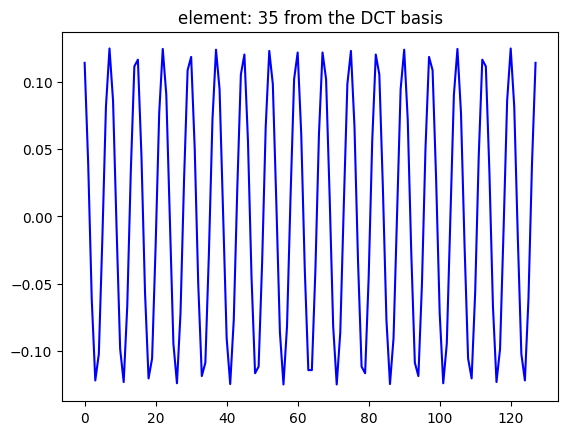

In [4]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [5]:
# if the dot product == 0 and col1!=col2, then: orthogonal
# if the dot product == 1 col1!=col2, then: orthogonal
# else: not orthogonal

is_DCT_orth = True
for i in range(M):
    for j in range(N):
        dot_product = DCT[:, i] @ DCT[:, j]
        if i != j:
            is_DCT_orth = np.isclose(dot_product, 0)
        else:
            is_DCT_orth = np.isclose(dot_product, 1)

        if(is_DCT_orth == False):
            break

print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

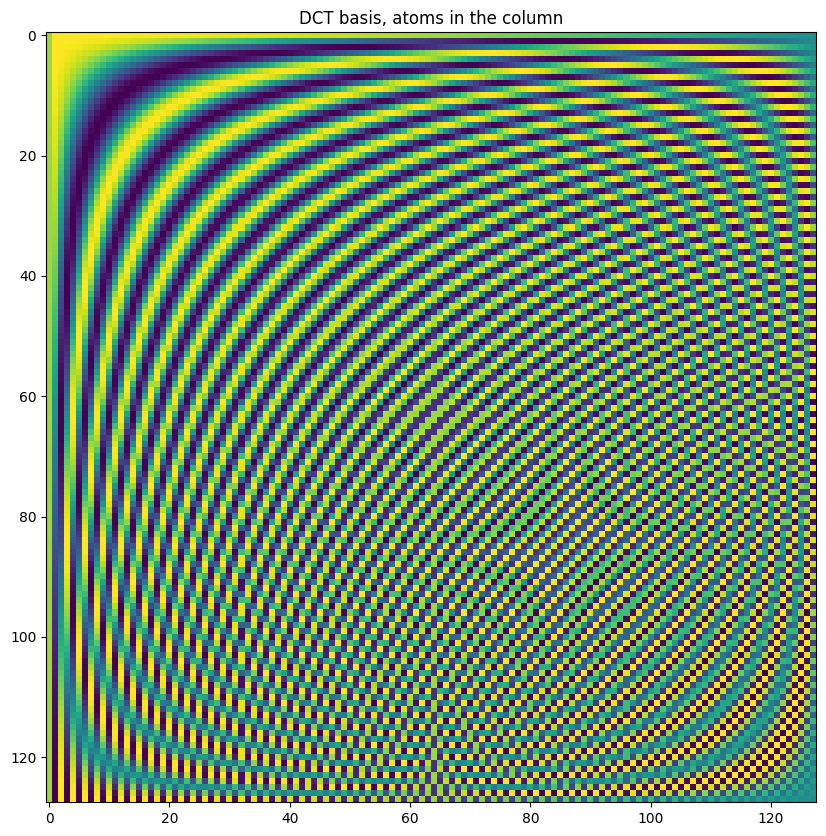

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [7]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')

Display the basis in the matrix

Text(0.5, 1.0, 'D basis, atoms in the column')

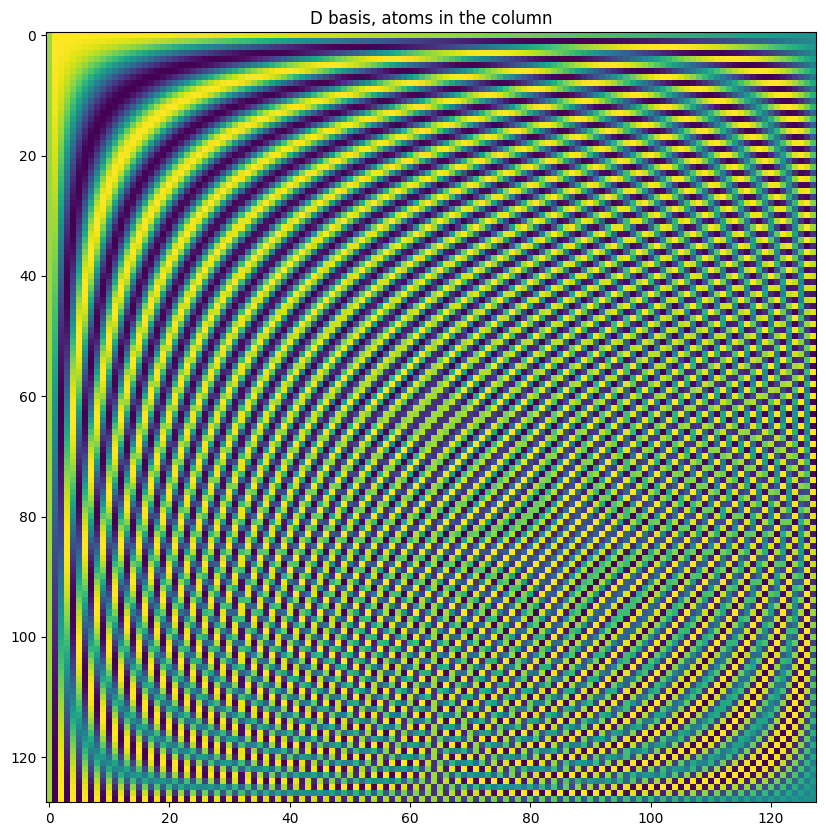

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title('D basis, atoms in the column')

Check that D and DCT defined above coincide

In [9]:
print(D[0][9])
print(DCT[0][9])

0.12423837125029451
0.12423837125029452


As you can see, they are almost equal, but not quite, that is why we'll use: `np.allclose()`

In [10]:
is_DCT_equal_D = np.allclose(D, DCT)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [11]:
temp = scipy.io.loadmat(f'{rootfolder}/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [12]:
for i in range(nBeats):
    X[:, i] = DCT.T @ S[:, i]

Text(0.5, 1.0, 'Visualize X')

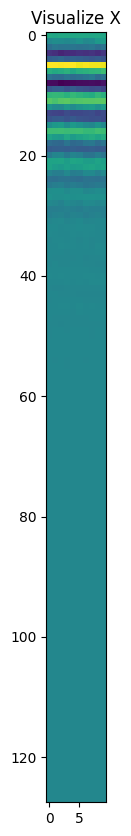

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(X)
plt.title('Visualize X')

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

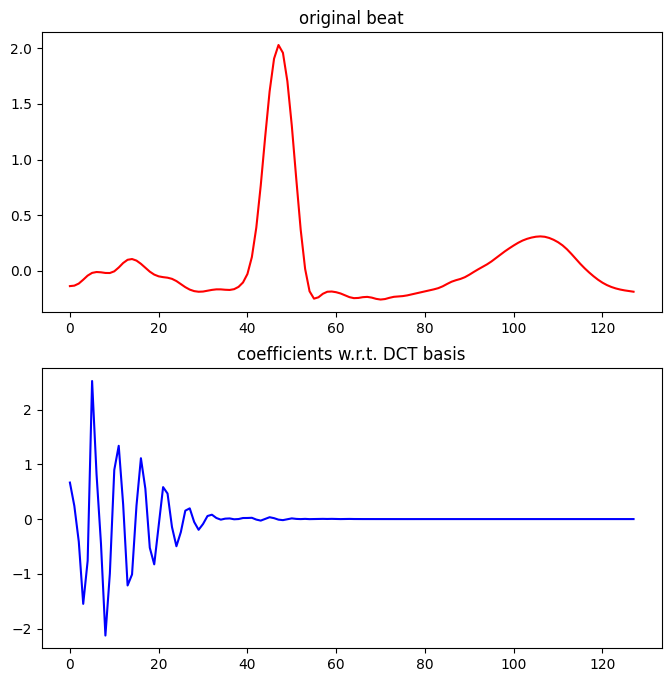

In [14]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

It is sparse because most of it's coefficients are close to zero

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [15]:
S_hat_D = D @ X
S_hat_D

array([[-0.14003424, -0.12265022, -0.13403224, ..., -0.12347035,
        -0.14238284, -0.1034781 ],
       [-0.12756344, -0.11873963, -0.1288756 , ..., -0.11216754,
        -0.13211001, -0.0874164 ],
       [-0.10789962, -0.10589241, -0.11589333, ..., -0.0956209 ,
        -0.11195404, -0.0672045 ],
       ...,
       [-0.17558314, -0.15957076, -0.1438405 , ..., -0.16976747,
        -0.16156176, -0.17280449],
       [-0.18140847, -0.15738024, -0.16608876, ..., -0.17828583,
        -0.17368397, -0.17678895],
       [-0.18692828, -0.15879004, -0.18690645, ..., -0.18487214,
        -0.18443889, -0.17976909]])

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [16]:
is_reconstruction_perfect = np.allclose(S,S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [17]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

S.shape
X.shape


(128, 10)

Compute the representation coefficients

In [18]:
for i in range(nBeats):
    X[:, i] = D.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

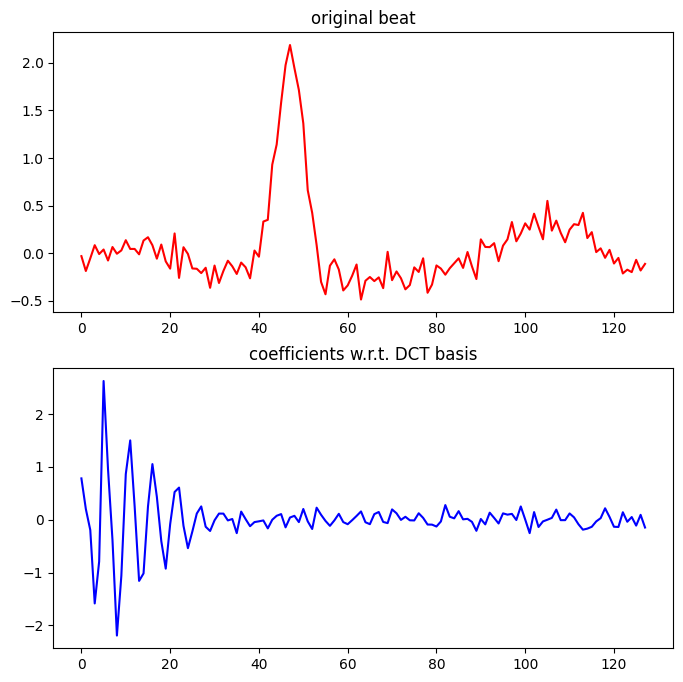

In [19]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [20]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
# L = 21 # sparsity level (try different values)
L = 35

for i in range(nBeats):
    origSignal = S0[:, i]
    noisySignal = S[:, i]

    # transform each signal separately (analysis)
    x = DCT.T @ noisySignal
    x = np.abs(x)
    x.sort()
    gamma = x[::-1][L-1]

    # keep only the L largest coefficients (absolute value)
    # print(X[:, i][0:10]<gamma)
    # print(X[:, i][0:10])
    # print(gamma)
    X_HT[:, i] = np.where(np.abs(X[:, i]) <= gamma, 0, X[:, i])
    # print(X_HT[:, i])
    
    # invert the transformation
    s_hat = DCT @ X_HT[:, i]

    S_hat[:, i] = s_hat


Display a signal

Text(0.5, 1.0, 'DCT coefficients')

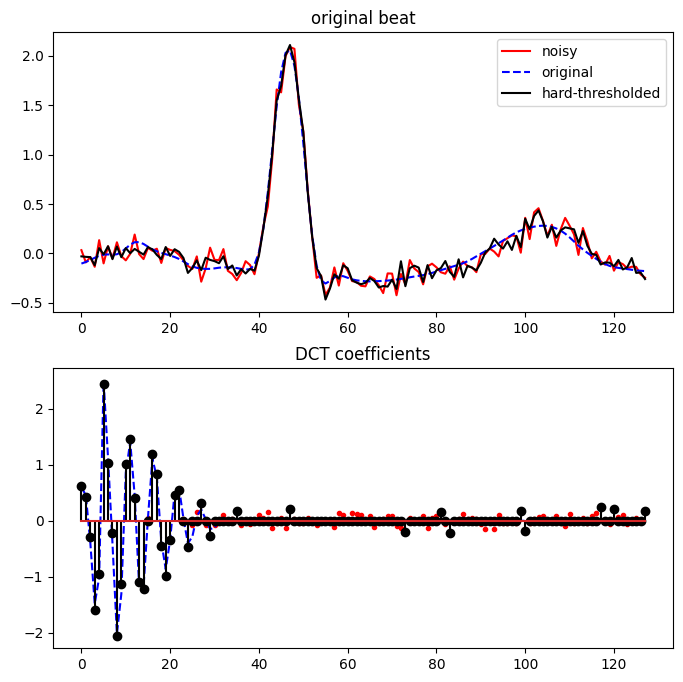

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

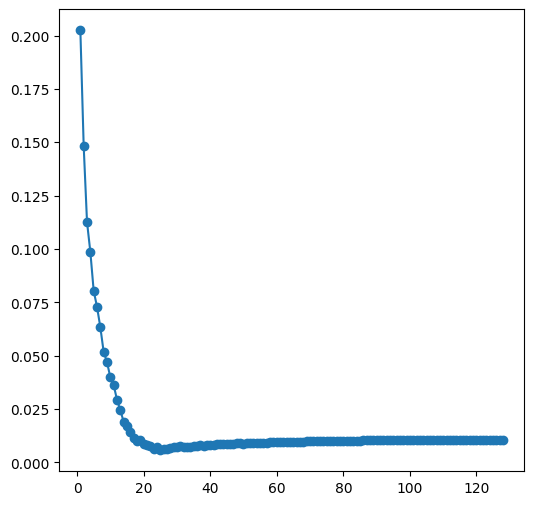

In [22]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)

MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
    # transform each signal separately (analysis)
    x = DCT.T @ origSignal
    x_orig = x.copy()
    x = np.abs(x)
    x.sort()
    gamma = x[::-1][L-1]

    # keep only the L largest coefficients (absolute value)
    #[...]
    x_HT = np.where(np.abs(x_orig) <= gamma, 0, x_orig)

    # invert the transformation
    s_hat = DCT @ x_HT

    mse = np.mean((S0[:,0] - s_hat)**2)

    MSE_values[L-1] = mse

plt.figure(figsize=(6,6))
plt.plot(L_values, MSE_values, '-o')